Epoch 0, Data Loss: 0.43652, Physics Loss: 0.01282
Epoch 200, Data Loss: 0.05976, Physics Loss: 0.00085
Epoch 400, Data Loss: 0.00114, Physics Loss: 0.00072
Epoch 600, Data Loss: 0.00014, Physics Loss: 0.00015
Epoch 800, Data Loss: 0.00002, Physics Loss: 0.00004


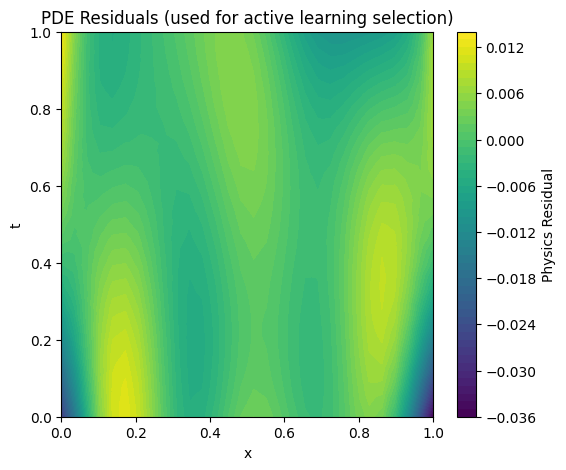

In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Heat equation parameters
alpha = 0.01  # thermal diffusivity

# Define the neural network model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.net(inputs)

# Physics-informed loss function
def physics_loss(model, x, t):
    x.requires_grad = True
    t.requires_grad = True
    u = model(x, t)

    u_t = autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

    residual = u_t - alpha * u_xx
    return torch.mean(residual**2), residual.detach().cpu().numpy()

# Create initial sparse data (initial condition: u(x, 0) = sin(pi * x))
def initial_data(n_samples):
    x = torch.linspace(0, 1, n_samples).reshape(-1, 1)
    t = torch.zeros_like(x)
    u = torch.sin(np.pi * x)
    return x.to(device), t.to(device), u.to(device)

# Generate test points for physics residual evaluation
def generate_grid(n_x, n_t):
    x = torch.linspace(0, 1, n_x)
    t = torch.linspace(0, 1, n_t)
    X, T = torch.meshgrid(x, t, indexing='ij')
    return X.reshape(-1, 1).to(device), T.reshape(-1, 1).to(device)

# Training loop
def train(model, x_data, t_data, u_data, x_phys, t_phys, epochs=1000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()

        u_pred = model(x_data, t_data)
        data_loss = torch.mean((u_pred - u_data) ** 2)

        phys_loss, _ = physics_loss(model, x_phys, t_phys)

        total_loss = data_loss + phys_loss
        total_loss.backward()
        optimizer.step()

        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Data Loss: {data_loss.item():.5f}, Physics Loss: {phys_loss.item():.5f}")

    return model

# Run initial training
n_initial = 10
x_data, t_data, u_data = initial_data(n_initial)
x_phys, t_phys = generate_grid(30, 30)

model = PINN().to(device)
model = train(model, x_data, t_data, u_data, x_phys, t_phys, epochs=1000)

# Evaluate residuals on the grid to identify high-error regions
_, residuals = physics_loss(model, x_phys, t_phys)
residuals = residuals.flatten()

# Visualize the residuals (for active learning decision)
x_phys_cpu = x_phys.detach().cpu().numpy()
t_phys_cpu = t_phys.detach().cpu().numpy()

plt.figure(figsize=(6, 5))
plt.tricontourf(x_phys_cpu.flatten(), t_phys_cpu.flatten(), residuals, levels=50)
plt.colorbar(label="Physics Residual")
plt.xlabel("x")
plt.ylabel("t")
plt.title("PDE Residuals (used for active learning selection)")
plt.show()
